## 1. Домен

Вибираємо наступний домен: письменники, книжки, які вони написали, та роки виходу книжок;

In [265]:
import pandas as pd
import numpy as np
import stanfordnlp
import re
from SPARQLWrapper import SPARQLWrapper, JSON
from IPython.display import Image
from nltk.stem import WordNetLemmatizer 

The SPARQL-query to acquire the data for this domain is defined bellow. In this case, we consider only book written in English.

In [2]:
sparql_query = """
    PREFIX dbo: <http://dbpedia.org/ontology/>
    PREFIX dbp: <http://dbpedia.org/property/>
    PREFIX res:  <http://dbpedia.org/resource/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT DISTINCT ?writer ?book ?date
    WHERE {
    ?writer rdf:type <http://dbpedia.org/ontology/Person> .
    ?writer dbo:notableWork ?book .
    ?book rdf:type <http://dbpedia.org/ontology/Book> .
    #?book dbo:language ?lang .
    #FILTER( ?lang IN (dbr:English_language, dbr:English)) .
    OPTIONAL {?book dbo:language dbr:English_language} .

    OPTIONAL {?book dbp:releaseDate ?date} .
    OPTIONAL {?book dbp:englishReleaseDate ?date} .
    OPTIONAL {?book dbp:pubDate ?date} .
    OPTIONAL {?book dbp:published ?date} .
    OPTIONAL {?book dbp:publicationDate ?date} .

}
"""

In [3]:
sparql = SPARQLWrapper("http://dbpedia.org/sparql")
sparql.setQuery(sparql_query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

In [4]:
def convert_from_dbpedia_book_str(dbpedia_book_str: str):
    book = re.sub(r'\(.*\)', '', dbpedia_book_str).replace('_', ' ').strip()
    return book

In [5]:
def acquire_years_from_string(s: str):
    if s is None:
        return []
    years = re.findall("(\d\d\d\d)", s)
    return set([int(year) for year in years])

In [6]:
def acquire_year_from_string(s: str):
    if s is None:
        return None
    year = re.search("(\d\d\d\d)", s)
    if year is None:
        return None
    return int(year[0])

In [7]:
def convert_sparql_result_to_data_frame(results):
    df_dict = {
        'writer' : [],
        'book': [],
        'year': []
    }
    
    for result in results["results"]["bindings"]:
        try:
            writer = result["writer"]["value"].split('/')[-1]
            book = result["book"]["value"].split('/')[-1]
            book = convert_from_dbpedia_book_str(book)
            year = acquire_years_from_string(result["date"]["value"])
                    
            df_dict['writer'].append(writer)
            df_dict['book'].append(book)
            df_dict['year'].append(year)
        except:
            continue
        
    return pd.DataFrame(df_dict)

In [8]:
def convert_sparql_result_to_writer_books_dict(results):
    writer_books_dict: Dict[str, Dict[str, List[int]]] = dict()
    for result in results["results"]["bindings"]:
        try:
            writer = result["writer"]["value"].split('/')[-1]
            book = result["book"]["value"].split('/')[-1]
            book = convert_from_dbpedia_book_str(book)
            years = acquire_years_from_string(result["date"]["value"])

            if writer not in writer_books_dict:
                writer_books_dict[writer] = dict()
            
            if book in writer_books_dict[writer]:
                writer_books_dict[writer][book].update(years)
            else:
                writer_books_dict[writer][book] = years
            
        except:
            continue
        
    return writer_books_dict

In [9]:
df = convert_sparql_result_to_data_frame(results)

In [10]:
df.head()

,writer,book,year
0,William_Makepeace_Thackeray,Vanity Fair,"{1848, 1847}"
1,Nalo_Hopkinson,Brown Girl in the Ring,{1998}
2,Theodore_Judson,Fitzpatrick's War,{2004}
3,Robert_M._Pirsig,Lila: An Inquiry into Morals,{1991}
4,Samuel_Beckett,Watt,{1953}


In [11]:
dbpedia_writer_books_dict = convert_sparql_result_to_writer_books_dict(results)

In [12]:
dbpedia_writer_books_dict

{'William_Makepeace_Thackeray': {'Vanity Fair': {1847, 1848}},
 'Nalo_Hopkinson': {'Brown Girl in the Ring': {1998},
  'Skin Folk': {2001},
  'The Salt Roads': {2003}},
 'Theodore_Judson': {"Fitzpatrick's War": {2004},
  "The Martian General's Daughter": {2008}},
 'Robert_M._Pirsig': {'Lila: An Inquiry into Morals': {1991},
  'Zen and the Art of Motorcycle Maintenance': {1974}},
 'Samuel_Beckett': {'Watt': {1953},
  'Murphy': {1938},
  'Malone Dies': {1951},
  'Molloy': {1951, 1955}},
 'Alan_Lawrence_Sitomer': {'The Hoopster': {2005},
  'Hip Hop High School': {2006},
  'Homeboyz': {2007}},
 'Ben_Cormack': {'The Story of Egmo': {2006}},
 'Melina_Marchetta': {'Looking for Alibrandi': {1992},
  'On the Jellicoe Road': {2006}},
 'Steele_Rudd': {'On Our Selection': {1899}},
 'Chinua_Achebe': {'Arrow of God': {1964},
  'A Man of the People': {1966},
  'Anthills of the Savannah': {1987},
  'No Longer at Ease': {1960},
  'Things Fall Apart': {1958}},
 'Eric_L._Harry': {'Arc Light': {1994}},
 '

In [13]:
len(dbpedia_writer_books_dict)

1336

## 2. Видобування фактів

In [14]:
import wikipediaapi
from typing import Dict, List, Tuple

In [15]:
wiki_en = wikipediaapi.Wikipedia('en')

2.1. Напишіть програму, яка шукає статті у Вікіпедії про сутності, що належать до вашого домена, та витягає тексти цих статей.

In [16]:
def acquire_wiki_text(wiki, page_name: str):
    page = wiki.page(page_name)
    if page.exists() is False:
        return None
    
    return page.text

In [17]:
writer_wikitext_dict: Dict[str, str] = dict()

In [18]:
for writer in dbpedia_writer_books_dict.keys():    
    wiki_text = acquire_wiki_text(wiki_en, writer)
    if wiki_text is None:
        continue
        
    writer_wikitext_dict[writer] = wiki_text

2.2. Напишіть програму, яка опрацьовує текст статті (саме сирий текст, а не таблички, якщо такі є) та витягає з нього інформацію про ваш домен. Цю інформацію ви будете порівнювати зі сформованою базою даних.

В більшості сторінок про письменииків з Вікіпедії є одна з секцій: "Works", "Books", "Published books" та інші (див. приклад знизу), де перераховані всі твори даного письменника. В такому разі, спрробуємо віднайти цю частинку "Works" з всього тексту вікі сторінки та витягти звідти всі сутності  WORK_OF_ART з роками. Якщо така секція існує у вікі сторінці, то немає сенсу розглядати інший контент сторінки. 

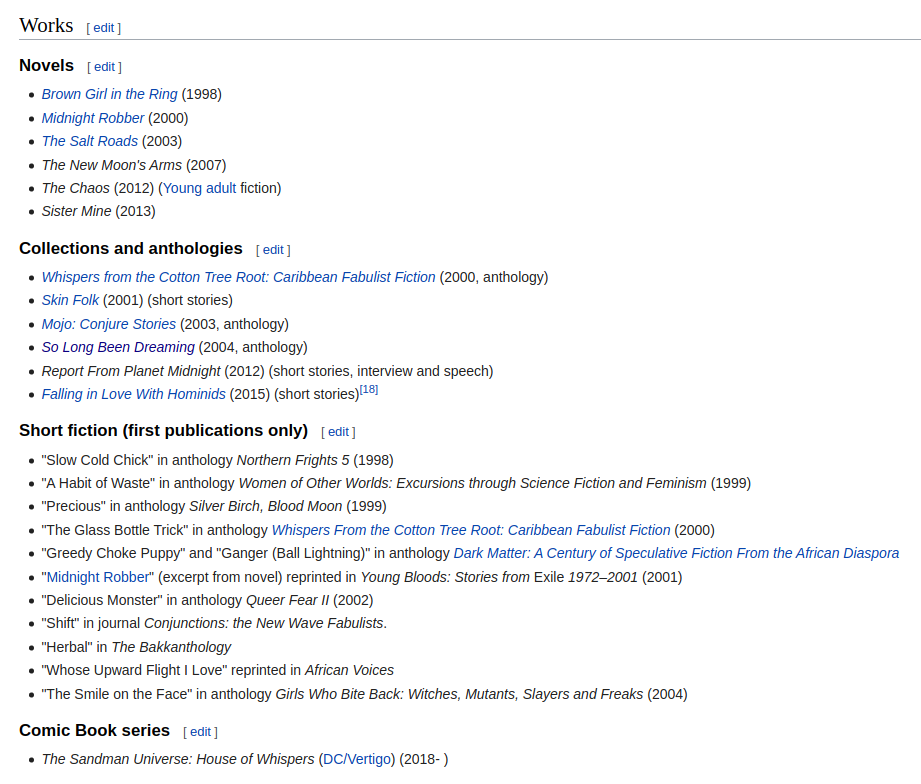

In [38]:
Image("img/wiki-works.png")

В протилежному випадку, якщо такої секції немає, наприклад як для письменників Theodore Judson, Robert M. Pirsig, Alan Duff то аналізуємо контент з вікі сторінки наступним чином: , 
- 

In [20]:
import spacy

In [325]:
class BookFinder:
    def __init__(self):
        #TODO: remove one loading and think how to use only one nlp
        self.nlp_simple = spacy.load("en_core_web_lg")
        self.nlp = spacy.load("en_core_web_lg")
        self.sentencizer = self.nlp.create_pipe("sentencizer")
        self.nlp.add_pipe(self.sentencizer)
        self.lemmatizer = WordNetLemmatizer()

    
    
    def find_books_written_by_author(self, author: str, author_description: str, use_only_ner = False):
        result: Dict[str, str] = dict()
        
        sentences: List[str] = self.sent_tokenize(author_description)
        i = 0
        for doc in self.nlp.pipe(sentences, disable=["tagger", "parser"]):
            book_with_pos_list = self._find_book_with_posisitons(doc.ents)
            for book, pos in book_with_pos_list:
                if use_only_ner is False:
                    if self.__check_if_work_of_art_written_by_author(author, book, sentences[i]) is False:
                        continue
                
                year = self._find_year_for_book(doc.ents, pos)
                if book not in result or result[book] is None:
                    result[book] = year
            i += 1
        return result

        
        
    def __find_books_written_by_author_use_only_ner(self, author_description: str):        
        result: Dict[str, str] = dict()
        
        sentences: List[str] = self.sent_tokenize(author_description)
        for doc in self.nlp.pipe(sentences, disable=["tagger", "parser"]):
            book_with_pos_list = self._find_book_with_posisitons(doc.ents)
            for book, pos in book_with_pos_list:
                year = self._find_year_for_book(doc.ents, pos)
                if book not in result or result[book] is None:
                    result[book] = year
        return result
    
    
    def sent_tokenize(self, text: str) -> List[str]:
        sentences = []
        for doc in self.nlp.pipe([text], disable=["tagger", "parser", "ner"]):
            for sent in doc.sents:
                sentences.append(sent.text)
        return sentences
    
    
    def _find_book_with_posisitons(self, entities):
        result = list()
        for i in range(0, len(entities)):
            if entities[i].label_ == 'WORK_OF_ART':
                result.append((entities[i].text, i))
        return result
    
    def _find_year_for_book(self, entities, book_pos):
        i = book_pos
        while i < len(entities):
            if entities[i].label_ == 'DATE':
                year = acquire_year_from_string(entities[i].text)
                if year is not None:
                    return year
            i += 1
        
        i = book_pos
        while i >= 0:
            if entities[i].label_ == 'DATE':
                year = acquire_year_from_string(entities[i].text)
                if year is not None:
                    return year
            i -= 1
            
        return None
    
    def __check_if_work_of_art_written_by_author(self, author: str, work_of_art: str, sentence: str):
        doc = self.nlp_simple(sentence)
        work_of_art_token = None
        for token in doc:
            if token.text in work_of_art:
                work_of_art_token = token
                break
        if work_of_art_token is None:
            return False

        cur_token = work_of_art_token
        for i in range(0, 100):
            head_token = cur_token.head
            if head_token.text == cur_token.text:
                break

            head_word = head_token.text.lower()
            if head_word in author.lower():
                return True

            if head_word in POTENTIONAL_HEADS_OF_WORK_OF_ART:
                return True

            head_lemma = self.__get_lemma(head_word)

            if head_lemma in POTENTIONAL_HEADS_OF_WORK_OF_ART:
                return True

            cur_token = head_token


        return False
    
    def __get_lemma(self, word: str):
        return self.lemmatizer.lemmatize(word)
    

In [338]:
class BookWikiFinder:
    
    DELTA_POS_BOOK_YEAR = 3   
    
    SECTIONS = ['\n\nWorks\n', '\n\nBooks\n', "\n\nPublished works\n", "\n\nMajor works\n", 
                "\n\nList of major works\n", '\n\nList of works\n', "\n\nSelected works\n", 
                '\n\nPublished books\n']
    
    BIBLIOGRAPHY_SECTION = "\n\nBibliography\n"
    
    REFERENCES_SECTION = "\n\nReferences\n"
    
    def __init__(self):        
        self.book_finder: BookFinder = BookFinder()

    
    def find_books_written_by_author(self, author: str, author_description: str, use_only_ner=False) -> Dict[str, str]:
        
        should_use_only_section, start_pos = self.__should_analyze_only_section(author_description)
        if should_use_only_section:
            section_text = self.__extract_section_text(author_description, start_pos)
            return self.book_finder.find_books_written_by_author(author, section_text, use_only_ner=True)
        
        return self.book_finder.find_books_written_by_author(author, author_description, use_only_ner=use_only_ner)
            
    def __should_analyze_only_section(self, author_description: str):
        for section in self.SECTIONS:
            pos = author_description.find(section)
            if pos != -1:
                return True, pos
        
        pos = author_description.find(self.BIBLIOGRAPHY_SECTION)
        if pos != -1:
            ref_pos = author_description.find(self.REFERENCES_SECTION)
            if ref_pos > pos:
                return True, pos
            
        
        return False, -1
    
    def __extract_section_text(self, author_description: str, start_pos: int):
        ref_pos = author_description.find(self.REFERENCES_SECTION)
        return author_description[start_pos: ref_pos]
    
    def __filter_author_description(self, author_description: str):
        return self.__extract_section_text(author_description, 0)


In [339]:
book_wiki_finder = BookWikiFinder()

In [340]:
book_wiki_finder.find_books_written_by_author('Nalo_Hopkinson', writer_wikitext_dict['Nalo_Hopkinson'])

{'Brown Girl in the Ring': 2003,
 'Slow Cold Chick': 1999,
 'A Habit of Waste': 1999,
 'Precious': 1999,
 'The Glass Bottle Trick': 2002,
 'Young Bloods: Stories from Exile': 2002,
 'Delicious Monster': 2002,
 'Queer Fear II': 2002,
 'Shift': 2002,
 'Conjunctions': 2002,
 'Herbal': None,
 'Whose Upward Flight I Love': None,
 'African Voices\n': None,
 'The Smile on the Face': None,
 'Girls Who Bite Back: Witches, Mutants, Slayers and Freaks (': None,
 'Comic Book': None,
 'The Sandman Universe: House of Whispers (DC/Vertigo': None}

Let's calculate the reselt for all writers 

In [355]:
wiki_writer_books_dict: Dict[str, Dict[str, str]] = dict()
for writer in dbpedia_writer_books_dict.keys():
    if writer not in wiki_writer_books_dict:
        wiki_writer_books_dict[writer] = dict()
    
    if writer not in writer_wikitext_dict:
        continue
        
    writer_wiki_description = writer_wikitext_dict[writer]
    wiki_writer_books_dict[writer] = book_wiki_finder.find_books_written_by_author(writer, writer_wiki_description, False)

## 3. Оцінювання результатів

Розробіть метрику, яка покаже, наскільки інформація, яку ви дістали зі статей, збігається з інформацією в вашій базі даних. Скільки пропущеної інформації? Чи є часткові збіги? (Наприклад, ім'я СЕО певної компанії збігається лише частково або ім'я СЕО збігається, а роки діяльності різні.)



In [349]:
def check_match_book(book: str, books_dict):
    for book_key in books_dict:
        if book in book_key:
            return book_key
        if book_key in book:
            return book_key
    return None

In [350]:
def are_years_matched(wiki_year, dbpedia_years):
    if len(dbpedia_years) == 0:
        if wiki_year is None:
            return True
        return False
    
    return wiki_year in  dbpedia_years

In [356]:
matched_dict = dict()
matched_result_dict = {
    'writer' : [],
    'num_dbpedia_books' : [],
    'num_wiki_books' : [],
    'matched_wiki_with_dbpedia_books' : [],
    'diff_num_dbpedia_and_wiki_books' : [],
    'matched_years_for_matched_books' : []
}
for writer in dbpedia_writer_books_dict:
    dbedia_books = dbpedia_writer_books_dict[writer]
    wiki_books = wiki_writer_books_dict[writer]
    
    
    matched_result_dict['writer'].append(writer)
    matched_result_dict['num_dbpedia_books'].append(len(dbedia_books))
    matched_result_dict['num_wiki_books'].append(len(wiki_books))
    matched_result_dict['diff_num_dbpedia_and_wiki_books'].append(len(dbedia_books) - len(wiki_books))
    
    matched_books, matched_year = 0, 0
    for dbedia_book in dbedia_books:
        wiki_book_matched = check_match_book(dbedia_book, wiki_books)
        
        if wiki_book_matched is None:
            continue
            
        matched_books += 1
        
        if are_years_matched(wiki_books[wiki_book_matched], dbedia_books[dbedia_book]):
            matched_year += 1
    
    if len(dbedia_books) > 0:
        matched_result_dict['matched_wiki_with_dbpedia_books'].append(matched_books / len(dbedia_books))
    else:
        if len(wiki_books) == 0:
            matched_result_dict['matched_wiki_with_dbpedia_books'].append(1)
        else:
            matched_result_dict['matched_wiki_with_dbpedia_books'].append(None)
            
    
    matched_years_for_matched_books = matched_year/ matched_books if matched_books > 0 else None                                                        
    matched_result_dict['matched_years_for_matched_books'].append(matched_years_for_matched_books )
                                                                                 
matched_result_df = pd.DataFrame(matched_result_dict)

Нижче представлена таблиця, де вказані коефіцієнти співпадіння книг що були витягнуті з вікіпедії та кних що отримані з dbedia, а також коефіцієнти спіпадіння років (у випадку якщо книги співпали) в яких були написані ці книги. Крім того також представлені кількість книг до кожного письменника, отримані з  dbpedia та вікіпедії, звідси видно що з вікіпедії отримується більше кількість книг для певного письменника ніж було отримано з dbpedia. 

In [357]:
matched_result_df

,writer,num_dbpedia_books,num_wiki_books,matched_wiki_with_dbpedia_books,diff_num_dbpedia_and_wiki_books,matched_years_for_matched_books
0,William_Makepeace_Thackeray,1,24,0.000000,-23,NaN
1,Nalo_Hopkinson,3,17,0.333333,-14,0.0
2,Theodore_Judson,2,4,0.000000,-2,NaN
3,Robert_M._Pirsig,2,0,0.000000,2,NaN
4,Samuel_Beckett,4,12,0.000000,-8,NaN
...,...,...,...,...,...,...
1331,Chinu_Modi,1,6,0.000000,-5,NaN
1332,Charlie_Jane_Anders,1,21,1.000000,-20,0.0
1333,Kavi_Kant,1,2,0.000000,-1,NaN
1334,Seth_Dickinson,1,5,1.000000,-4,1.0


In [358]:
matched_books = matched_result_df['matched_wiki_with_dbpedia_books'].values
matched_books = matched_books[matched_books != np.array(None)]
print("The average matched book coefficient: ", 100 * np.average(matched_books), "%")

The average matched book coefficient:  38.040407280676746 %


Коефіцієнт що вище був розраховний лише на визначенні NER як WORK_OF_ART, з урахуванням того що при знаходженні певної секції розглядається лише певна секція (Works, Books, ...). Враховуючи попередню імплементацію даний коефіцієн був 39.22%, він зменшився з урахвуванням того що при врахуванні лише певних секцій деякі книги могли б не врахвуватись. 

In [354]:
matched_books = matched_result_df['matched_wiki_with_dbpedia_books'].values
matched_books = matched_books[matched_books != np.array(None)]
print("The average matched book coefficient: ", 100 * np.average(matched_books), "%")

The average matched book coefficient:  26.51880762284954 %


Даний коефіцієнт, вже розраховний (    wiki_writer_books_dict[writer] = book_wiki_finder.find_books_written_by_author(writer, writer_wiki_description, False) ) з урахуванням певних  секцій (Works, Books, ...) та в тих випадках де ці секції не були знайдені додаткова перевірка правил чи даний WORK_OF_ART належить певному автору чи ні. Те що коефіцієн є меншим, пояснюється тим що чимало книг могло б відфільтруватись правилом BookFinder.__check_if_work_of_art_written_by_author <br/>

Крім того, цей коефіцієнт показує що можливо правило є надто строгим і варто його більш розширити аби не відфільтровувати важливі WORK_OF_ART, проте воно так само могло відфільтрувати нам інші WORK_OF_ART що не є книгами. 

Можливо даний коефіцієнт буде здаватися за високим, враховуючи що визначення книжок було реалізовна лише на іменних сутностях. Це пояснюватиметься тим, що кількість книг отриманих зі сторінки wikipedia значно переважає кількість кних отриманих з dbpedia, що збільшує ймовірність того що певна книга з dbpedia знайдеться в книгах отриманиз з wiki.

In [347]:
matched_years = matched_result_df['matched_years_for_matched_books'].values
matched_years = matched_years[~np.isnan(matched_years)]
print("The average matched years coefficient, where books are matched: ", 100 * np.average(matched_years), "%")

The average matched years coefficient, where books are matched:  41.89739413680782 %


Підвищення коефіцієнту (42% > 37%) по рокам пояснюється тим що додалась імплементація де визначались книги з певної секції вікіпедії про автора (Works, Books) і якщо уважно придивитись  на сторінку будь якого письменника ( https://en.wikipedia.org/wiki/Nalo_Hopkinson#Works ) то помітимо що біля книги одразу написано рік її видання. 

In [337]:
diff = matched_result_df['diff_num_dbpedia_and_wiki_books'].values
print("The average difference between number of dbpedia books and num of wiki books", np.average(diff))

The average difference between number of dbpedia books and num of wiki books -5.058383233532934


Як бачимо середня різниця є від'ємною та досить суттєвою, це пов'язано з тим що переважно в більшості випадків у wikipedia вказано значно більше книг написаних тим чи іншим письменником. Для прикладу розглянемо дані з  dbpedia про Nalo Hopkinson (http://dbpedia.org/page/Nalo_Hopkinson) і бачимо що тут вказано лише три книги (dbo:notableWork) в той час чк на сторінці wikipedia згадано значно більше (https://en.wikipedia.org/wiki/Nalo_Hopkinson). 